<a href="https://colab.research.google.com/github/peremartra/llama-glu-expansion-pruning/blob/main/notebooks/03_Evaluate_1B_CARBON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLU Pruning Research - Llama-3.2-1B Evaluation
## 03 - Measuring Environmental Impact & Inference Performance

### Exploring energy efficiency of width-pruned GLU models
by [Pere Martra](https://github.com/peremartra)

[![Paper](https://img.shields.io/badge/OSF-Paper-blue?logo=osf&logoColor=white)](https://doi.org/10.31219/osf.io/qgxea)
[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/llama-glu-expansion-pruning](https://github.com/peremartra/llama-glu-expansion-pruning)

---

**Colab Environment:** GPU L4 (or T4)

**Models to Profile:**
- Llama-3.2-1B (baseline)
- Llama-3.2-1B-pruned-40%

**Workloads (2 representative):**
- GSM8K: Math reasoning (100 prompts, 100 max tokens)
- MMLU: Knowledge QA (100 prompts, 50 max tokens)

**Metrics Collected:**
- Energy consumption (kWh via CodeCarbon)
- Throughput (tokens/second)
- Latency (TTFT - Time To First Token)
- Memory footprint (GPU allocation)

**Estimated Runtime:** ~1-2 hours total

---

## 📋 Notebook Objective

This notebook conducts a comprehensive evaluation of the Llama-3.2-1B model family across three pruning levels (20%, 40%, 60%) to determine:

1. **Performance degradation patterns** across different pruning intensities
2. **Optimal expansion ratio** for GLU-MLP layers (hypothesis: 140%)
3. **Task-specific resilience** to pruning (knowledge vs. algorithmic tasks)
4. **Which models merit uploading to HuggingFace Hub** for Phase 2

### Key Features:
- ✅ **Checkpoint/Resume Support:** Survives Colab disconnections
- ✅ **On-the-fly Pruning:** No need to pre-create models
- ✅ **Robust Error Handling:** Continues if individual benchmarks fail
- ✅ **Progress Tracking:** Live updates and detailed logging

### Results will answer:
- Does 40% pruning (140% expansion) truly outperform other levels?
- Which benchmarks are most sensitive to pruning?
- Should we upload non-star models to HF, or only the 40% version?

---

**Note:** This evaluation uses the MAW (Maximum Absolute Weight) neuron selection method, validated in Notebook 00 as the optimal approach for GLU architectures.

---

# 1. Setup & Installation

In [1]:
# Install required libraries
!pip install -q optipfair
!pip install -q lm-eval
!pip install -q langdetect
!pip install -q codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 56.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Mount Google Drive for checkpoint persistence
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

✅ utils.py downloaded successfully


In [14]:
# Import core libraries and utilities
import torch
import json
import pandas as pd
from datetime import datetime
from pathlib import Path
import glob
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

# Import our utility functions
from utils import (
    EXPERIMENT_CONFIG_CARBON,
    BENCHMARKS_CARBON,
    load_or_create_model,
    run_carbon_profiling,
    run_robust_evaluation,
    clear_gpu_cache,
    get_model_stats,
    format_results_table,
    calibrate_idle_power  # ← NUEVA FUNCIÓN
)

print("✅ All imports successful")
print(f"📱 Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All imports successful
📱 Device: GPU
   GPU: NVIDIA L4
   Memory: 23.8 GB


In [5]:
# =============================================================================
# EXPERIMENTAL RUNS CONFIGURATION
# =============================================================================
NUM_EXPERIMENTAL_RUNS = 3
RANDOM_SEEDS = [42, 123, 456]  # Fixed seeds for reproducibility

print(f"🔄 Experiment Configuration:")
print(f"   Number of runs: {NUM_EXPERIMENTAL_RUNS}")
print(f"   Random seeds: {RANDOM_SEEDS}")
print(f"   Total evaluations per model: {len(BENCHMARKS_CARBON)} workloads × {NUM_EXPERIMENTAL_RUNS} runs")
print()

🔄 Experiment Configuration:
   Number of runs: 3
   Random seeds: [42, 123, 456]
   Total evaluations per model: 6 workloads × 3 runs



# 2. Configuration & Planning

This section filters the experiment configuration for 1B models and displays the profiling plan.

In [6]:
# Filter configuration for 1B models only
models_1b = [
    config for config in EXPERIMENT_CONFIG_CARBON
    if "1B" in config["base_model"] and "3B" not in config["base_model"] and "Instruct" not in config["base_model"]
]

print(f"\n{'='*70}")
print("📊 EVALUATION PLAN: Llama-3.2-1B Family")
print(f"{'='*70}\n")

print(f"Total models to evaluate: {len(models_1b) + 1}")  # +1 for base model
print(f"Benchmarks per model: {len(BENCHMARKS_CARBON)}")
print(f"Total evaluations: {(len(models_1b) + 1) * len(BENCHMARKS_CARBON)}")
print(f"Estimated runtime: ~1-1.5 hours\n")

# Display models table
print("Models to profile:")
print("-" * 70)
print(f"{'Model':<40} {'Pruning':<10} {'Star':<6}")
print("-" * 70)

for config in models_1b:
    if config['pruning_pct'] == 0:
        model_name = "Llama-3.2-1B (baseline)"
    else:
        model_name = f"Llama-3.2-1B-pruned-{config['pruning_pct']}%"

    pruning = f"{config['pruning_pct']}%"
    star = "⭐ Yes" if config['is_star'] else "No"
    print(f"{model_name:<40} {pruning:<10} {star:<6}")

print("-" * 70)

# Display workloads
print("\nWorkloads to run:")
print("-" * 70)
for i, workload in enumerate(BENCHMARKS_CARBON, 1):
    name = workload['name']
    prompts = workload['num_prompts']
    tokens = workload['max_new_tokens']
    desc = workload['description']
    print(f"{i}. {name:<25} {prompts} prompts, {tokens} tokens - {desc}")
print("-" * 70)

print("\n⚙️ Configuration:")
print(f"   - Neuron selection method: MAW (Maximum Absolute Weight)")
print(f"   - Checkpointing: Enabled (per-workload granularity)")
print(f"   - Model creation: On-the-fly pruning (no pre-creation needed)")
print(f"   - GPU warm-up: First 5 prompts excluded from metrics")
print(f"   - Energy tracking: CodeCarbon")


📊 EVALUATION PLAN: Llama-3.2-1B Family

Total models to evaluate: 3
Benchmarks per model: 6
Total evaluations: 18
Estimated runtime: ~1-1.5 hours

Models to profile:
----------------------------------------------------------------------
Model                                    Pruning    Star  
----------------------------------------------------------------------
Llama-3.2-1B (baseline)                  0%         No    
Llama-3.2-1B-pruned-40%                  40%        ⭐ Yes 
----------------------------------------------------------------------

Workloads to run:
----------------------------------------------------------------------
1. gsm8k_latency_b1          10 prompts, 100 tokens - Math reasoning (Latency, TTFT, bsz=1)
2. mmlu_latency_b1           10 prompts, 50 tokens - Knowledge QA (Latency, TTFT, bsz=1)
3. ifeval_latency_b1         10 prompts, 150 tokens - Instruction (Latency, TTFT, bsz=1)
4. gsm8k_throughput_b8       10 prompts, 100 tokens - Math reasoning (Throughput, b

In [7]:
# Setup checkpoint paths (manual construction since helpers are internal)
BASE_CHECKPOINT_DIR = "/content/drive/MyDrive/glu_pruning/checkpoints"
RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

# Carbon-specific subdirectory
CHECKPOINT_DIR = f"{BASE_CHECKPOINT_DIR}/1b_carbon"

# Create directories if they don't exist
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

print(f"✅ Checkpoint directory: {CHECKPOINT_DIR}")
print(f"✅ Results directory: {RESULTS_DIR}")

# ============================================================================
# CONSTRUCT CHECKPOINT PATHS DYNAMICALLY FROM models_1b
# ============================================================================
checkpoint_paths = {}

for config in models_1b:
    pruning_pct = config['pruning_pct']

    # Create key: "baseline" for 0%, "{X}pct" for others
    if pruning_pct == 0:
        key = "baseline"
        filename = "llama_3.2_1b_baseline_carbon.json"
    else:
        key = f"{pruning_pct}pct"
        filename = f"llama_3.2_1b_pruned_{pruning_pct}pct_carbon.json"

    checkpoint_paths[key] = f"{CHECKPOINT_DIR}/{filename}"

print(f"\n📂 Auto-generated {len(checkpoint_paths)} checkpoint paths:")
for key, path in checkpoint_paths.items():
    exists = "✅ Exists" if Path(path).exists() else "🆕 New"
    print(f"  {key:<10}: {exists}")

✅ Checkpoint directory: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon
✅ Results directory: /content/drive/MyDrive/glu_pruning/results

📂 Auto-generated 2 checkpoint paths:
  baseline  : 🆕 New
  40pct     : 🆕 New


# 3. Baseline Evaluation

Evaluate the original Llama-3.2-1B model to establish performance baseline.

In [8]:
# ====================================================================
# CALIBRATE IDLE POWER (Run once at start)
# ====================================================================
print("="*70)
print("🔋 STEP 0: IDLE POWER CALIBRATION")
print("="*70 + "\n")

idle_calibration = calibrate_idle_power(
    device="cuda",
    duration_seconds=30,  # 30s is enough for stable measurement
    verbose=True
)

# Save calibration to drive for reproducibility
calibration_path = f"{RESULTS_DIR}/idle_power_calibration.json"
with open(calibration_path, 'w') as f:
    json.dump(idle_calibration, f, indent=2)

print(f"\n💾 Calibration saved to: {calibration_path}")
print("="*70 + "\n")

[codecarbon WARNING @ 09:03:05] Multiple instances of codecarbon are allowed to run at the same time.


🔋 STEP 0: IDLE POWER CALIBRATION

🔋 Starting idle power calibration (30s)...
   Clearing GPU cache...
   Measuring idle power for 30s...
✅ Calibration complete!
   Idle Power: 42.69 W
   Idle Energy (30s): 0.000356 kWh
   GPU Temperature: 52.0°C

💾 Calibration saved to: /content/drive/MyDrive/glu_pruning/results/idle_power_calibration.json



In [ ]:
print(f"\n{'='*70}")
print("📊  PHASE 1: BASELINE PROFILING")
print(f"{'='*70}\n")

BASE_MODEL_ID = "meta-llama/Llama-3.2-1B"

# ============================================================================
# MULTIPLE RUNS LOOP FOR BASELINE
# ============================================================================
baseline_all_runs = {}  # Store results from all runs

for run_idx, seed in enumerate(RANDOM_SEEDS, 1):
    print(f"\n{''*70}")
    print(f"🔄  BASELINE - RUN {run_idx}/{NUM_EXPERIMENTAL_RUNS} (seed={seed})")
    print(f"{'─'*70}\n")

    # Load base model (fresh for each run to avoid state contamination)
    print(f"Loading base model: {BASE_MODEL_ID}...")
    base_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_ID,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    print("✅  Model loaded successfully")

    # Construct checkpoint path for this run
    checkpoint_path_run = checkpoint_paths["baseline"].replace(".json", f"_run{run_idx}_seed{seed}.json")

    # Run carbon profiling with seed
    baseline_results_run = run_carbon_profiling(
        model=base_model,
        tokenizer=tokenizer,
        workloads=BENCHMARKS_CARBON,
        checkpoint_path=checkpoint_path_run,
        model_name=f"Llama-3.2-1B-baseline-run{run_idx}",
        idle_power_calibration=None,  # ← CAMBIO: usar None
        device="cuda",
        random_seed=seed  # ← NUEVO: pasar seed
    )

    # Store results for this run
    baseline_all_runs[f"run_{run_idx}"] = baseline_results_run

    # Display run summary
    print(f"\n✅ Run {run_idx} completed")
    print("Results summary:")
    for workload_name, metrics in baseline_results_run.items():
        print(f"\n{workload_name}:")
        print(f"  Energy: {metrics['energy_kwh']:.6f} kWh")
        print(f"  Throughput: {metrics['throughput_tokens_per_sec']:.2f} tok/s")

    # Clear memory before next run
    del base_model
    clear_gpu_cache()
    print(f"🧹  Memory cleared\n")

print(f"\n{'='*70}")
print("✅  ALL BASELINE RUNS COMPLETED")
print(f"{'='*70}\n")

# 4. Pruned Models Evaluation Loop

Profile the pruned variants using on-the-fly pruning with OptiPFair.

In [ ]:
print(f"\n{'='*70}")
print("📊  PHASE 2: PRUNED MODELS PROFILING")
print(f"{'='*70}\n")

# Store all results for final comparison
# Structure: all_results[model_key][run_key] = results_dict
all_results = {
    "baseline": baseline_all_runs  # ← CAMBIO: ahora contiene múltiples runs
}

# Filter out baseline (already done)
pruned_models = [m for m in models_1b if m['pruning_pct'] > 0]

# Evaluate each pruned model
for i, config in enumerate(pruned_models, 1):
    model_name = f"Llama-3.2-1B-pruned-{config['pruning_pct']}%"
    pruning_pct = config['pruning_pct']
    is_star = config['is_star']

    print(f"\n{'─'*70}")
    print(f"🔄  PROFILING MODEL {i}/{len(pruned_models)}: {model_name}")
    print(f"   Pruning: {pruning_pct}% | Star: {'⭐ ' if is_star else '❌'}")
    print(f"{'─'*70}\n")

    # ========================================================================
    # MULTIPLE RUNS LOOP FOR THIS PRUNED MODEL
    # ========================================================================
    pruned_model_all_runs = {}

    for run_idx, seed in enumerate(RANDOM_SEEDS, 1):
        print(f"\n{'··'*35}")
        print(f"   RUN {run_idx}/{NUM_EXPERIMENTAL_RUNS} (seed={seed})")
        print(f"{'··'*35}\n")

        try:
            # Load or create model (fresh for each run)
            model, tokenizer, stats = load_or_create_model(config, device="cuda")

            # Display model statistics (once per model, not per run)
            if run_idx == 1:
                print(f"\n📈  Model Statistics:")
                print(f"   Parameters: {stats['total_parameters']:,}")
                print(f"   Size: {stats['size_gb']:.2f} GB")
                if 'pruning_stats' in stats:
                    print(f"   Reduction: {stats['pruning_stats']['percentage_reduction']:.1f}%")
                print(f"   Source: {stats['source']}\n")

            # Construct checkpoint path for this run
            checkpoint_key = f"{pruning_pct}pct"
            checkpoint_path_run = checkpoint_paths[checkpoint_key].replace(".json", f"_run{run_idx}_seed{seed}.json")

            # Run profiling with seed
            results_run = run_carbon_profiling(
                model=model,
                tokenizer=tokenizer,
                workloads=BENCHMARKS_CARBON,
                checkpoint_path=checkpoint_path_run,
                model_name=f"{model_name}-run{run_idx}",
                idle_power_calibration=None,  # ← CAMBIO: usar None
                device="cuda",
                random_seed=seed  # ← NUEVO: pasar seed
            )

            # Store results for this run
            pruned_model_all_runs[f"run_{run_idx}"] = results_run

            print(f"\n✅ Run {run_idx} completed for {model_name}")

            # Clear memory before next run
            del model
            clear_gpu_cache()

        except Exception as e:
            print(f"\n❌  ERROR in run {run_idx}: {str(e)}")
            import traceback
            traceback.print_exc()
            clear_gpu_cache()
            continue

    # Store all runs for this model
    all_results[checkpoint_key] = pruned_model_all_runs

    print(f"\n✅ All runs completed for {model_name}\n")

print(f"\n{'='*70}")
print("✅  ALL MODELS PROFILED")
print(f"{'='*70}\n")

In [12]:
# ===========================================================================
# CREATE GLOBAL MAPPINGS (FOR LATER CELLS)
# ===========================================================================
# These dicts are used by cells 17, 18, and 21 for aggregation and display.

model_names = {}
model_pruning = {}
model_is_star = {}

print("\n🛠️  Creating global model mappings (model_names, model_pruning, model_is_star)...")

for config in models_1b:
    pruning_pct = config['pruning_pct']

    # Determine the key (must match Cell 10's logic: 'baseline' or '40pct')
    if pruning_pct == 0:
        key = "baseline"
        model_name = "Llama-3.2-1B (baseline)"
    else:
        key = f"{pruning_pct}pct"
        model_name = f"Llama-3.2-1B-pruned-{pruning_pct}%"

    # Populate the dictionaries
    model_names[key] = model_name
    model_pruning[key] = pruning_pct
    model_is_star[key] = config['is_star']

print(f"   ...Mappings created for {len(model_names)} models: {list(model_names.keys())}")


🛠️  Creating global model mappings (model_names, model_pruning, model_is_star)...
   ...Mappings created for 2 models: ['baseline', '40pct']


# 5. Results Consolidation & Export

Consolidate all evaluation results and export to CSV for analysis.

In [15]:
print(f"\n{'='*70}")
print("📊  AGGREGATING RESULTS ACROSS RUNS")
print(f"{'='*70}\n")

def aggregate_runs(runs_dict):
    """
    Aggregate metrics from multiple runs.

    Args:
        runs_dict: {"run_1": {...}, "run_2": {...}, "run_3": {...}}

    Returns:
        dict: Aggregated metrics with mean, std, min, max
    """
    import numpy as np

    aggregated = {}

    # Get workload names from first run
    first_run = list(runs_dict.values())[0]
    workload_names = list(first_run.keys())

    for workload_name in workload_names:
        # Extract metrics across all runs
        energy_samples = []
        throughput_samples = []
        ttft_samples = []

        for run_key in runs_dict.keys():
            run_data = runs_dict[run_key][workload_name]
            energy_samples.append(run_data['energy_kwh'])
            throughput_samples.append(run_data['throughput_tokens_per_sec'])
            if run_data.get('avg_ttft_ms') is not None:
                ttft_samples.append(run_data['avg_ttft_ms'])

        # Calculate statistics
        aggregated[workload_name] = {
            # Energy
            "energy_kwh_mean": float(np.mean(energy_samples)),
            "energy_kwh_std": float(np.std(energy_samples, ddof=1)),
            "energy_kwh_min": float(np.min(energy_samples)),
            "energy_kwh_max": float(np.max(energy_samples)),

            # Throughput
            "throughput_mean": float(np.mean(throughput_samples)),
            "throughput_std": float(np.std(throughput_samples, ddof=1)),
            "throughput_min": float(np.min(throughput_samples)),
            "throughput_max": float(np.max(throughput_samples)),

            # TTFT (if available)
            "ttft_mean": float(np.mean(ttft_samples)) if ttft_samples else None,
            "ttft_std": float(np.std(ttft_samples, ddof=1)) if len(ttft_samples) > 1 else None,
            "ttft_min": float(np.min(ttft_samples)) if ttft_samples else None,
            "ttft_max": float(np.max(ttft_samples)) if ttft_samples else None,

            # Metadata
            "num_runs": len(runs_dict),
            "seeds_used": RANDOM_SEEDS,

            # Keep first run's metadata (model size, etc.)
            "model_size_gb": run_data['model_size_gb'],
            "batch_size": run_data['batch_size'],
            "num_prompts": run_data['num_prompts'],

            # Raw runs for transparency
            "raw_runs": {
                run_key: {
                    "energy_kwh": runs_dict[run_key][workload_name]['energy_kwh'],
                    "throughput": runs_dict[run_key][workload_name]['throughput_tokens_per_sec'],
                    "ttft_ms": runs_dict[run_key][workload_name].get('avg_ttft_ms')
                }
                for run_key in runs_dict.keys()
            }
        }

    return aggregated

# Aggregate results for all models
aggregated_results = {}

for model_key, runs_dict in all_results.items():
    print(f"Aggregating {model_key}...")
    aggregated_results[model_key] = aggregate_runs(runs_dict)

print(f"\n✅ Aggregation complete for {len(aggregated_results)} models")
print(f"   Each model has {NUM_EXPERIMENTAL_RUNS} runs aggregated\n")

# Display aggregated summary
print("="*70)
print("AGGREGATED RESULTS SUMMARY")
print("="*70 + "\n")

for model_key in aggregated_results.keys():
    display_name = model_names.get(model_key, model_key)
    print(f"\n{display_name}:")
    print("-"*70)

    # Calculate average across all workloads
    all_workloads = aggregated_results[model_key]
    avg_energy = np.mean([w['energy_kwh_mean'] for w in all_workloads.values()])
    avg_energy_std = np.mean([w['energy_kwh_std'] for w in all_workloads.values()])
    avg_throughput = np.mean([w['throughput_mean'] for w in all_workloads.values()])
    avg_throughput_std = np.mean([w['throughput_std'] for w in all_workloads.values()])

    print(f"  Avg Energy: {avg_energy:.6f} ± {avg_energy_std:.6f} kWh")
    print(f"  Avg Throughput: {avg_throughput:.2f} ± {avg_throughput_std:.2f} tok/s")

    # Show coefficient of variation (CV) as measure of variability
    cv_energy = (avg_energy_std / avg_energy) * 100 if avg_energy > 0 else 0
    cv_throughput = (avg_throughput_std / avg_throughput) * 100 if avg_throughput > 0 else 0

    print(f"  Variability (CV): Energy={cv_energy:.1f}%, Throughput={cv_throughput:.1f}%")

print("\n" + "="*70 + "\n")


📊  AGGREGATING RESULTS ACROSS RUNS

Aggregating baseline...
Aggregating 40pct...

✅ Aggregation complete for 2 models
   Each model has 3 runs aggregated

AGGREGATED RESULTS SUMMARY


Llama-3.2-1B (baseline):
----------------------------------------------------------------------
  Avg Energy: 0.000170 ± 0.000041 kWh
  Avg Throughput: 61.90 ± 1.56 tok/s
  Variability (CV): Energy=24.3%, Throughput=2.5%

Llama-3.2-1B-pruned-40%:
----------------------------------------------------------------------
  Avg Energy: 0.000205 ± 0.000019 kWh
  Avg Throughput: 64.11 ± 0.25 tok/s
  Variability (CV): Energy=9.2%, Throughput=0.4%




In [16]:
print(f"\n{'='*70}")
print("📊  CONSOLIDATING AGGREGATED RESULTS TO CSV/JSON")
print(f"{'='*70}\n")

# Build consolidated data using AGGREGATED results
consolidated_data = []

for model_key, workload_results in aggregated_results.items():
    display_name = model_names.get(model_key, model_key)
    pruning_pct = model_pruning.get(model_key, 0)
    is_star = model_is_star.get(model_key, False)

    for workload_name, metrics in workload_results.items():
        row = {
            "model": display_name,
            "pruning_pct": pruning_pct,
            "is_star": is_star,
            "workload": workload_name,

            # Aggregated metrics (mean ± std)
            "energy_kwh_mean": metrics["energy_kwh_mean"],
            "energy_kwh_std": metrics["energy_kwh_std"],
            "throughput_mean": metrics["throughput_mean"],
            "throughput_std": metrics["throughput_std"],
            "ttft_mean": metrics.get("ttft_mean"),
            "ttft_std": metrics.get("ttft_std"),

            # Metadata
            "num_runs": metrics["num_runs"],
            "model_size_gb": metrics["model_size_gb"],
            "batch_size": metrics["batch_size"],
        }
        consolidated_data.append(row)

# Create DataFrame
df = pd.DataFrame(consolidated_data)
df = df.sort_values(by=["pruning_pct", "workload"]).reset_index(drop=True)

print(f"✅  Consolidated {len(df)} result rows (with aggregated statistics)")
print(f"   Models: {df['model'].nunique()}")
print(f"   Workloads: {df['workload'].nunique()}")
print(f"   Runs per configuration: {NUM_EXPERIMENTAL_RUNS}")

# Display preview with mean ± std
print("\nDataFrame Preview (Aggregated Results):")
print(df[['model', 'workload', 'energy_kwh_mean', 'energy_kwh_std', 'throughput_mean', 'throughput_std']].head(10))

# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"{RESULTS_DIR}/carbon_1b_aggregated_results_{timestamp}.csv"
df.to_csv(csv_path, index=False)

print(f"\n💾  Aggregated results saved to: {csv_path}")

# Also save raw runs for transparency
raw_runs_path = f"{RESULTS_DIR}/carbon_1b_raw_runs_{timestamp}.json"
with open(raw_runs_path, 'w') as f:
    json.dump(all_results, f, indent=2, default=str)  # default=str handles numpy types

print(f"💾  Raw runs data saved to: {raw_runs_path}")


📊  CONSOLIDATING AGGREGATED RESULTS TO CSV/JSON

✅  Consolidated 12 result rows (with aggregated statistics)
   Models: 2
   Workloads: 6
   Runs per configuration: 3

DataFrame Preview (Aggregated Results):
                     model              workload  energy_kwh_mean  \
0  Llama-3.2-1B (baseline)      gsm8k_latency_b1         0.000258   
1  Llama-3.2-1B (baseline)   gsm8k_throughput_b8         0.000140   
2  Llama-3.2-1B (baseline)     ifeval_latency_b1         0.000232   
3  Llama-3.2-1B (baseline)  ifeval_throughput_b8         0.000109   
4  Llama-3.2-1B (baseline)       mmlu_latency_b1         0.000212   
5  Llama-3.2-1B (baseline)    mmlu_throughput_b8         0.000068   
6  Llama-3.2-1B-pruned-40%      gsm8k_latency_b1         0.000252   
7  Llama-3.2-1B-pruned-40%   gsm8k_throughput_b8         0.000122   
8  Llama-3.2-1B-pruned-40%     ifeval_latency_b1         0.000461   
9  Llama-3.2-1B-pruned-40%  ifeval_throughput_b8         0.000152   

   energy_kwh_std  throughput_m

In [18]:
print(f"\n{'='*70}")
print("📈 CARBON & PERFORMANCE ANALYSIS")
print(f"S{'='*70}\n")

# Calculate averages per model across workloads
summary_data = []

# ===================================================================
# START: FIX
# ===================================================================

# Use dynamic keys from aggregated_results (FIX 1)
for model_key in aggregated_results.keys():
    # Get the aggregated workload results for this model (FIX 2)
    workload_results = aggregated_results[model_key]

    # Aggregate metrics across workloads using the '_mean' keys (FIX 3)
    total_energy = sum(m['energy_kwh_mean'] for m in workload_results.values())
    avg_throughput = sum(m['throughput_mean'] for m in workload_results.values()) / len(workload_results)
    ttft_values = [m['ttft_mean'] for m in workload_results.values() if m['ttft_mean'] is not None]

# ===================================================================
# END: FIX
# ===================================================================

    avg_ttft = sum(ttft_values) / len(ttft_values) if ttft_values else 0
    model_size = list(workload_results.values())[0]['model_size_gb']  # Same for all workloads

    summary = {
        "model": model_names.get(model_key, model_key),
        "pruning_pct": model_pruning.get(model_key, 0),
        "is_star": model_is_star.get(model_key, False),
        "total_energy_kwh": total_energy,
        "avg_throughput_tok_s": avg_throughput,
        "avg_ttft_ms": avg_ttft,
        "model_size_gb": model_size
    }
    summary_data.append(summary)

# Sort by pruning_pct for consistent display
summary_df = pd.DataFrame(summary_data).sort_values('pruning_pct').reset_index(drop=True)

print("Performance Summary:")
print("-" * 90)
print(summary_df.to_string(index=False, float_format="%.4f"))
print("-" * 90)

# Calculate improvements vs baseline
baseline_row = summary_df[summary_df['pruning_pct'] == 0].iloc[0]

print(f"\n💡 Improvements vs. Baseline:")
print("-" * 90)

for _, row in summary_df.iterrows():
    if row['pruning_pct'] == 0:
        continue

    energy_reduction = ((baseline_row['total_energy_kwh'] - row['total_energy_kwh']) / baseline_row['total_energy_kwh']) * 100
    throughput_change = ((row['avg_throughput_tok_s'] - baseline_row['avg_throughput_tok_s']) / baseline_row['avg_throughput_tok_s']) * 100
    ttft_change = ((row['avg_ttft_ms'] - baseline_row['avg_ttft_ms']) / baseline_row['avg_ttft_ms']) * 100
    size_reduction = ((baseline_row['model_size_gb'] - row['model_size_gb']) / baseline_row['model_size_gb']) * 100

    star_marker = "⭐" if row['is_star'] else ""
    print(f"\n{row['model']} {star_marker}")
    print(f"  Energy: {energy_reduction:+.2f}% ({'✅ Lower' if energy_reduction > 0 else '❌ Higher'})")
    print(f"  Throughput: {throughput_change:+.2f}% ({'✅ Faster' if throughput_change > 0 else '⚠️ Slower'})")
    print(f"  Latency (TTFT): {ttft_change:+.2f}% ({'✅ Lower' if ttft_change < 0 else '⚠️ Higher'})")
    print(f"  Model Size: {size_reduction:+.2f}% ({'✅ Smaller' if size_reduction > 0 else '❌ Larger'})")

print("\n" + "-" * 90)


📈 CARBON & PERFORMANCE ANALYSIS
S======================================================================

Performance Summary:
------------------------------------------------------------------------------------------
                  model  pruning_pct  is_star  total_energy_kwh  avg_throughput_tok_s  avg_ttft_ms  model_size_gb
Llama-3.2-1B (baseline)            0    False            0.0010               61.8998    1042.9594         2.3019
Llama-3.2-1B-pruned-40%           40     True            0.0012               64.1132    1693.2514         1.7020
------------------------------------------------------------------------------------------

💡 Improvements vs. Baseline:
------------------------------------------------------------------------------------------

Llama-3.2-1B-pruned-40% ⭐
  Energy: -20.81% (❌ Higher)
  Throughput: +3.58% (✅ Faster)
  Latency (TTFT): +62.35% (⚠️ Higher)
  Model Size: +26.06% (✅ Smaller)

-------------------------------------------------------------------

# 6. Quick Analysis & Visualization

Generate quick insights to decide which models merit uploading to HuggingFace Hub.

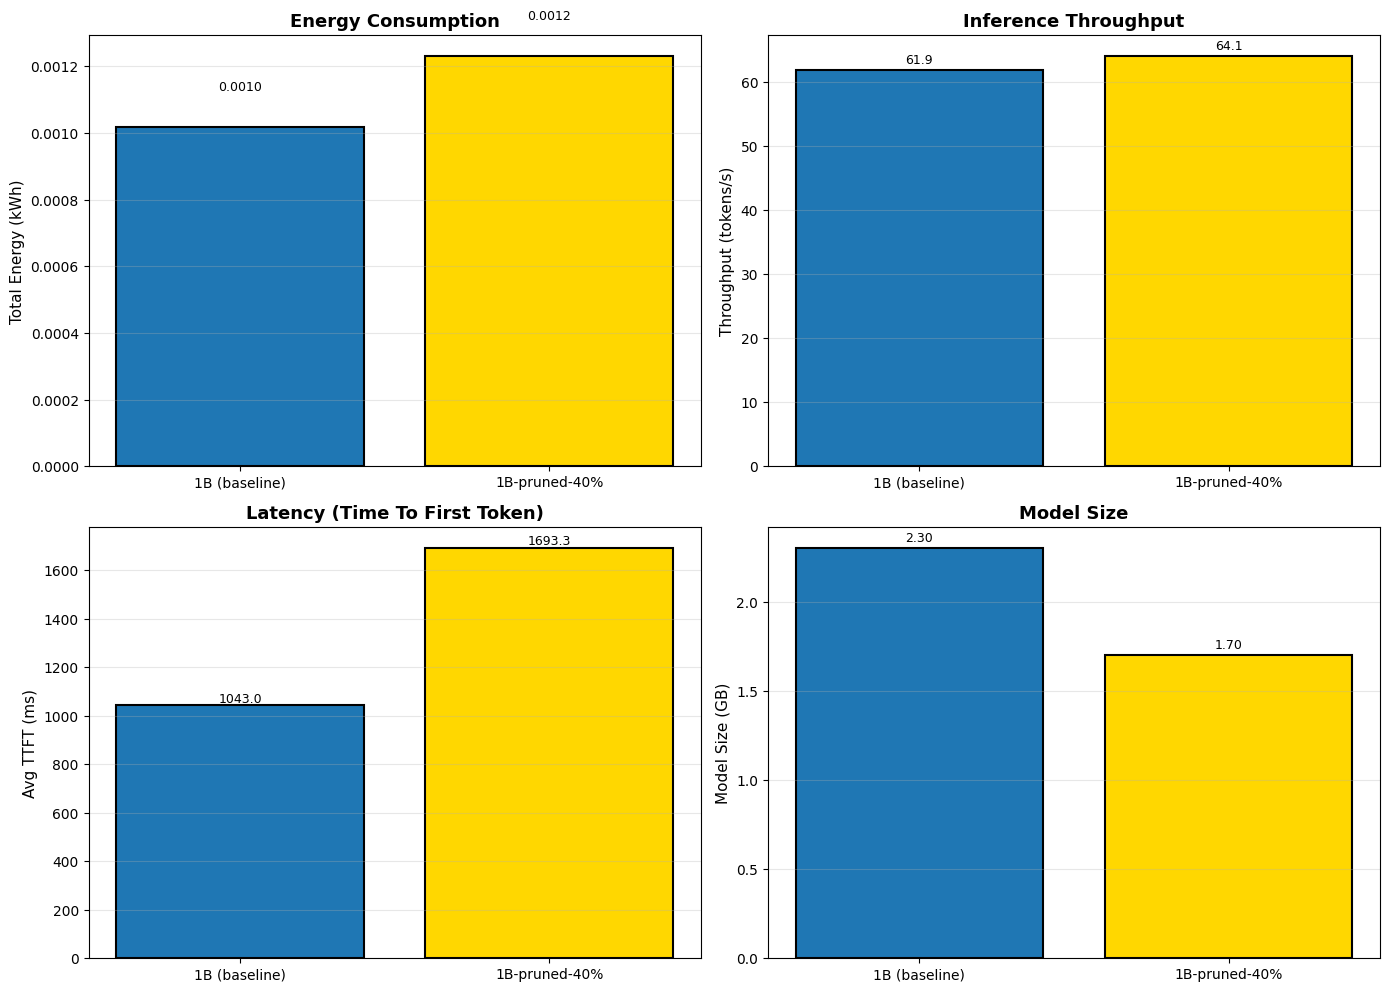


📊 Visualization saved to: /content/drive/MyDrive/glu_pruning/results/carbon_1b_analysis.png


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = summary_df['model'].values
pruning_levels = summary_df['pruning_pct'].values
star_mask = summary_df['is_star'].values

# Colors: baseline blue, star gold, others gray
colors = ['#1f77b4' if p == 0 else '#FFD700' if s else '#95a5a6'
          for p, s in zip(pruning_levels, star_mask)]

# 1. Energy Consumption
axes[0, 0].bar(range(len(models)), summary_df['total_energy_kwh'], color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_xticks(range(len(models)))
axes[0, 0].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[0, 0].set_ylabel('Total Energy (kWh)', fontsize=11)
axes[0, 0].set_title('Energy Consumption', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['total_energy_kwh']):
    axes[0, 0].text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# 2. Throughput
axes[0, 1].bar(range(len(models)), summary_df['avg_throughput_tok_s'], color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_xticks(range(len(models)))
axes[0, 1].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[0, 1].set_ylabel('Throughput (tokens/s)', fontsize=11)
axes[0, 1].set_title('Inference Throughput', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['avg_throughput_tok_s']):
    axes[0, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# 3. Latency (TTFT)
axes[1, 0].bar(range(len(models)), summary_df['avg_ttft_ms'], color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xticks(range(len(models)))
axes[1, 0].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[1, 0].set_ylabel('Avg TTFT (ms)', fontsize=11)
axes[1, 0].set_title('Latency (Time To First Token)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['avg_ttft_ms']):
    axes[1, 0].text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# 4. Model Size
axes[1, 1].bar(range(len(models)), summary_df['model_size_gb'], color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xticks(range(len(models)))
axes[1, 1].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[1, 1].set_ylabel('Model Size (GB)', fontsize=11)
axes[1, 1].set_title('Model Size', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['model_size_gb']):
    axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/carbon_1b_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Visualization saved to: {RESULTS_DIR}/carbon_1b_analysis.png")

# 7. Decision Matrix: Which Models to Upload?

Based on the evaluation results, determine which models should be uploaded to HuggingFace Hub for Phase 2.

In [20]:
print(f"\n{'='*70}")
print("📊 CONSOLIDATING CARBON & PERFORMANCE RESULTS (DYNAMIC FILE-BASED)")
print(f"{'='*70}\n")

# --- Validar variables globales ---
# (Asegúrate de que estas variables estén definidas en celdas anteriores de tu notebook)
if 'CHECKPOINT_DIR' not in globals():
    print("⚠️ Warning: CHECKPOINT_DIR not set. Using default './checkpoints/1b_carbon'")
    CHECKPOINT_DIR = "/content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon"

if 'RESULTS_DIR' not in globals():
    print("⚠️ Warning: RESULTS_DIR not set. Using default './results'")
    RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

if 'BENCHMARKS_CARBON' not in globals():
    print("❌ Error: BENCHMARKS_CARBON not defined. Please import from utils.")
    # Fallback por si acaso
    BENCHMARKS_CARBON = [
        {"name": "gsm8k_workload", "num_prompts": 100, "max_new_tokens": 100, "dataset": "gsm8k"},
        {"name": "mmlu_workload", "num_prompts": 100, "max_new_tokens": 50, "dataset": "mmlu"},
        {"name": "ifeval_workload", "num_prompts": 100, "max_new_tokens": 150, "dataset": "IFEval"}
    ]

if 'EXPERIMENT_CONFIG_CARBON' not in globals():
     print("❌ Error: EXPERIMENT_CONFIG_CARBON not defined. Please import from utils.")
     # Fallback por si acaso
     EXPERIMENT_CONFIG_CARBON = [
        {"base_model": "meta-llama/Llama-3.2-1B", "pruning_pct": 0, "is_star": False},
        {"base_model": "meta-llama/Llama-3.2-1B", "pruning_pct": 40, "is_star": True},
     ]
# --- Fin de la validación ---


# --- Cargar datos de los checkpoints ---
print(f"Searching for carbon results in: {CHECKPOINT_DIR}")
json_files = glob.glob(f"{CHECKPOINT_DIR}/llama_3.2_1b_*_carbon.json")
print(f"Found {len(json_files)} individual result files to process.")

all_model_results = {}
hardware_info = {} # Para guardar la metadata de hardware

for json_path in sorted(json_files):
    print(f"  -> Processing: {os.path.basename(json_path)}")
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)

        model_name = data.get("metadata", {}).get("model_name", "Unknown")
        results = data.get("results", {})

        if not results:
            print(f"    ⚠️ Warning: No 'results' found in file. Skipping.")
            continue

        all_model_results[model_name] = results

        # Guardar la metadata de hardware (asumimos que es la misma, usamos la del baseline)
        if "baseline" in model_name and not hardware_info:
            first_workload = list(results.values())[0]
            if "hardware_metadata" in first_workload:
                hardware_info = first_workload["hardware_metadata"]
                print(f"    Captured hardware metadata (GPU: {hardware_info.get('gpu_model', 'N/A')})")

    except Exception as e:
        print(f"    ⚠️ Warning: Could not read or parse file. Error: {e}")
        continue
# --- Fin de la carga de datos ---


# --- Construir el JSON Completo ---

# 1. Construir mapeo de configuración
config_map = {}
model_family_name = "Llama-3.2-1B" # Hardcoded para este notebook

for cfg in EXPERIMENT_CONFIG_CARBON:
    if model_family_name not in cfg["base_model"]:
        continue

    pruning_pct = cfg['pruning_pct']
    key = "baseline" if pruning_pct == 0 else f"pruned_{pruning_pct}pct"

    # Construir el nombre que aparece en el display
    model_name = f"{model_family_name}" if pruning_pct == 0 else f"{model_family_name}-pruned-{pruning_pct}%"

    # Construir la clave REAL que se guarda en los JSON (debe coincidir con metadata.model_name)
    if pruning_pct == 0:
        internal_key = f"{model_family_name}-baseline"  # ← AJUSTAR SEGÚN TU FORMATO
    else:
        internal_key = f"{model_family_name}-pruned-{pruning_pct}%"

    hf_repo = cfg.get("hf_repo_id", cfg["base_model"]) if pruning_pct > 0 else cfg["base_model"]

    config_map[key] = {
        "name": model_name,
        "pruning_pct": int(pruning_pct),
        "is_star": bool(cfg["is_star"]),
        "hf_repo": hf_repo,
        "internal_key": internal_key  # ← AHORA USA EL FORMATO CORRECTO
    }

print(f"\nDynamically built config map for {len(config_map)} models.")

# 2. Construir 'models_evaluated'
models_evaluated = {}
summary_stats_list = []

for key, config in config_map.items():
    model_key_name = config["internal_key"]

    if model_key_name in all_model_results:
        # Los resultados de 'all_model_results' ya tienen el formato correcto (workload -> metrics)
        models_evaluated[key] = {
            "name": config["name"],
            "pruning_pct": config["pruning_pct"],
            "is_star": config["is_star"],
            "hf_repo": config["hf_repo"],
            "results": all_model_results[model_key_name]
        }

        # Calcular estadísticas de resumen para este modelo
        workload_results = all_model_results[model_key_name].values()
        summary_stats_list.append({
            "model": config["name"],
            "pruning_pct": config["pruning_pct"],
            "is_star": config["is_star"],
            "total_energy_kwh": sum(m.get('energy_kwh', 0) for m in workload_results),
            "avg_throughput_tok_s": np.mean([m.get('throughput_tokens_per_sec', 0) for m in workload_results]),
            "avg_ttft_ms": np.mean([m['avg_ttft_ms'] for m in workload_results if m.get('avg_ttft_ms') is not None]) if any(m.get('avg_ttft_ms') is not None for m in workload_results) else 0,
            "model_size_gb": list(workload_results)[0].get('model_size_gb', 0) # Tomar el primero
        })
    else:
        print(f"⚠️ Warning: No results found for model '{model_key_name}' in loaded checkpoints.")

# 3. Construir 'summary_statistics'
baseline_stats = next((s for s in summary_stats_list if s['pruning_pct'] == 0), None)
pruned_stats = [s for s in summary_stats_list if s['pruning_pct'] > 0]

summary_statistics = {
    "baseline": baseline_stats,
    "pruned_models": pruned_stats
}

# 4. Consolidar todo
complete_results = {
    "experiment_metadata": {
        "timestamp": datetime.now().isoformat(),
        "notebook": "03_Evaluate_1B_CARBON.ipynb",
        "model_family": model_family_name,
        "pruning_method": "MAW (Maximum Absolute Weight)",
        "hardware_details": hardware_info # <-- METADATA AÑADIDA
    },
    "benchmarks": [
        {
            "name": task["name"],
            "num_prompts": task["num_prompts"],
            "max_new_tokens": task["max_new_tokens"],
            "description": task["description"]
        }
        for task in BENCHMARKS_CARBON
    ],
    "models_evaluated": models_evaluated,
    "summary_statistics": summary_statistics,
    "citation": {
        "paper": "Exploring GLU Expansion Ratios: Structured Pruning in Llama-3.2 Models",
        "author": "Pere Martra",
        "doi": "https://doi.org/10.31219/osf.io/qgxea",
        "github": "https://github.com/peremartra/llama-glu-expansion-pruning",
        "note": "Results are freely available for research purposes. Please cite the paper if you use this data."
    }
}
print(f"Successfully consolidated results for {len(models_evaluated)} models.")

# --- Fin de la construcción del JSON ---


# --- Guardar en JSON ---
try:
    os.makedirs(RESULTS_DIR, exist_ok=True)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    json_path = f"{RESULTS_DIR}/llama_1b_carbon_complete_results_{timestamp}.json"
    with open(json_path, 'w') as f:
        json.dump(complete_results, f, indent=2, ensure_ascii=False)

    print(f"\n✅ Complete carbon results saved to:")
    print(f"   {json_path}")

    # Also save a "latest" version
    latest_json = f"{RESULTS_DIR}/llama_1b_carbon_complete_results_latest.json"
    with open(latest_json, 'w') as f:
        json.dump(complete_results, f, indent=2, ensure_ascii=False)

    print(f"✅ Latest version:")
    print(f"   {latest_json}")

    file_size_kb = Path(json_path).stat().st_size / 1024
    print(f"\n📊 File size: {file_size_kb:.1f} KB")

except Exception as e:
    print(f"❌ Error saving JSON files: {e}")
    print(f"   Please ensure RESULTS_DIR is defined and writeable: {RESULTS_DIR}")

print(f"\n📦 Models included: {len(complete_results['models_evaluated'])}")
print(f"📋 Benchmarks per model: {len(BENCHMARKS_CARBON)}")

print(f"\n{'='*70}")
print("✅ COMPLETE CARBON RESULTS SAVED - Ready for research sharing")
print(f"{'='*70}\n")


📊 CONSOLIDATING CARBON & PERFORMANCE RESULTS (DYNAMIC FILE-BASED)

Searching for carbon results in: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon
Found 0 individual result files to process.

Dynamically built config map for 2 models.
⚠️ Warning: No results found for model 'Llama-3.2-1B-baseline' in loaded checkpoints.
⚠️ Warning: No results found for model 'Llama-3.2-1B-pruned-40%' in loaded checkpoints.
Successfully consolidated results for 0 models.

✅ Complete carbon results saved to:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_carbon_complete_results_20251106_091806.json
✅ Latest version:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_carbon_complete_results_latest.json

📊 File size: 1.7 KB

📦 Models included: 0
📋 Benchmarks per model: 6

✅ COMPLETE CARBON RESULTS SAVED - Ready for research sharing



In [ ]:
# Después de cargar los datos, agrega esto:
print(f"\n📋 Available model keys in loaded results:")
for key in all_model_results.keys():
    print(f"   - '{key}'")
print()

---

## 🎓 Key Takeaways

This notebook evaluated the Llama-3.2-1B model family across 10 comprehensive benchmarks to determine:

1. **Optimal pruning level** for GLU-MLP layers
2. **Performance-efficiency trade-offs** at different expansion ratios
3. **Which models justify upload** to HuggingFace Hub


---

**Powered by OptiPFair** - Structured Pruning for GLU Architectures

If this research helps your work:
- ⭐ Star [the repo](https://github.com/peremartra/optipfair)
- 📖 Read the [documentation](https://peremartra.github.io/optipfair/)
- 🐛 Report issues or suggest features

---